## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [28]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    ori_img = cv2.imread(fname)
    img = ori_img
    base_name  = os.path.basename(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        #print(corners.shape)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        output_name_original = "../output_images/" + base_name
        cv2.imwrite(output_name_original,img)
        print(output_name_original)
        #cv2.imshow(fname,img)
        #cv2.waitKey(500)
        
cv2.destroyAllWindows()

#undistort all the check board
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
for fname in images:
    img = cv2.imread(fname)
    base_name  = os.path.basename(fname)
    undist1 = cv2.undistort(img, mtx, dist, None, mtx)
    output_name_undist = "../output_images/undist_" + base_name
    cv2.imwrite(output_name_undist,undist1)
    
    
    
    
    










../output_images/calibration6.jpg
../output_images/calibration7.jpg
../output_images/calibration3.jpg
../output_images/calibration2.jpg
../output_images/calibration20.jpg
../output_images/calibration19.jpg
../output_images/calibration18.jpg
../output_images/calibration15.jpg
../output_images/calibration14.jpg
../output_images/calibration16.jpg
../output_images/calibration17.jpg
../output_images/calibration13.jpg
../output_images/calibration12.jpg
../output_images/calibration10.jpg
../output_images/calibration11.jpg
../output_images/calibration9.jpg
../output_images/calibration8.jpg


## Helper functions for binary threshholding and perspective transformation

In [19]:
#compute gradient dir thresh hold
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    sobel_x_abs = np.absolute(sobel_x)
    sobel_y_abs = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(sobel_y_abs, sobel_x_abs)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(arctan)
    # 6) Return this mask as your binary_output image
    dir_binary[(arctan >=thresh[0]) & (arctan <= thresh[1]) ] =1 
    
    return dir_binary

#compute the magnitute threshold
def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel_x = cv2.Sobel(img, cv2.CV_64F,1,0,sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F,0,1,sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel =np.sqrt(sobel_x**2 + sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    mag_binary = np.zeros_like(scaled_sobel)
   
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

#gradient threshhold on the x dir
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize =sobel_kernel ) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #applying the mask
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbinary

#color threshold on staturation
def color_threshold(img,s_thresh_min=170,s_thresh_max = 255 ):
    s_binary = np.zeros_like(img)
    s_binary[(img >= s_thresh_min) & (img <= s_thresh_max)] = 1
    
    return s_binary

#given image do perspective transform
def perspect_transform(img,src,dst):
    
    img_size = (img.shape[1], img.shape[0])
    M =cv2.getPerspectiveTransform(src,dst)
    Minv =cv2.getPerspectiveTransform(dst,src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return Minv,warped

#take the image as well as the veteices of the area of the interest plot the area on the graph
def show_area_interest(undist,src,dst):
    plt.imshow(undist)
    plt.plot(src[:,0],src[:,1] , 'b--', lw=2)
    plt.plot(dst[:,0],dst[:,1] , 'r--', lw=2)
    
    return

#take in the undist image apply threshold and return bird eye transfromed image and the inverse transform matrix
def bird_eye_transform(undist):
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)

    #apply a color transformed binary image
    # Sobel x
    sxbinary = abs_sobel_thresh(gray,sobel_kernel=3,thresh=(20, 100))

    #directional gradient threshold
    dir_binary = dir_threshold(gray, sobel_kernel=3, thresh=(0.7, 1.3))

    #magnitute threshold
    mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 150))

    # Threshold color channel
    s_binary = color_threshold(s_channel,s_thresh_min=170,s_thresh_max = 255 )
    # Threshold light channel
    l_binary = color_threshold(l_channel,s_thresh_min=100,s_thresh_max = 255 )

    #combine color mask and x gradient mask
    combined_binary = np.zeros_like(sxbinary)
    grad_binary = ((mag_binary ==1) &(sxbinary == 1) & (dir_binary ==1))
    combined_binary[((s_binary == 1) & (l_binary == 1))| (sxbinary == 1)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), grad_binary, s_binary)) * 255
    
    #define transform source and dst points and perform transform
    src = np.float32([[580,458],[280,680],[1095,675],[732,457]])
    dst = np.float32([[200,0], [200,680],  [1000,680],[1000,0]])
    Minv, bird_eye = perspect_transform(combined_binary,src, dst)
    
    return Minv, bird_eye







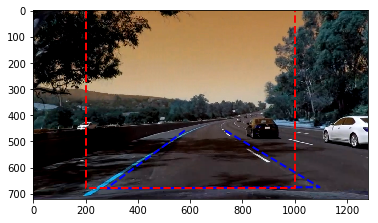

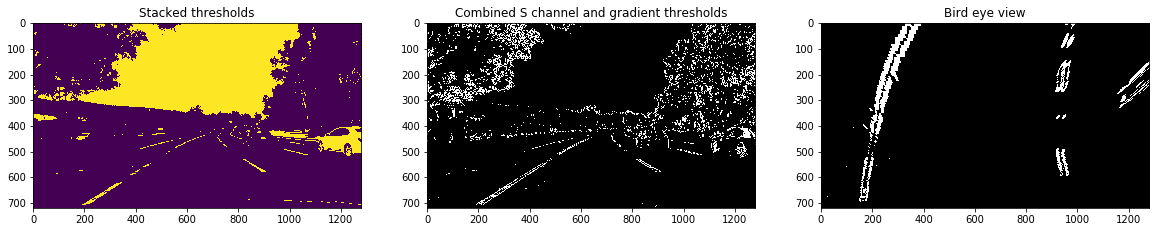

In [21]:
#now we have the mtx, dist of the camera so we can undistort the camera
#%pylab inline
img = cv2.imread("../test_images/shadow2.png")

#undistrot the image
#check the distortion of the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite("undist.jpg",undist)




# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)

#apply a color transformed binary image
# Sobel x
sxbinary = abs_sobel_thresh(gray,sobel_kernel=3,thresh=(20, 100))

#directional gradient threshold
dir_binary = dir_threshold(gray, sobel_kernel=3, thresh=(0.7, 1.3))

#magnitute threshold
mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 150))

# Threshold saturation channel
s_binary = color_threshold(s_channel,s_thresh_min=220,s_thresh_max = 255 )
# Threshold light channel
l_binary = color_threshold(l_channel,s_thresh_min=100,s_thresh_max = 255 )


#combine color mask and x gradient mask
combined_binary = np.zeros_like(sxbinary)
grad_binary = ((mag_binary ==1) &(sxbinary == 1) & (dir_binary ==1))

combined_binary[(s_binary == 1) & (l_binary ==1)| (sxbinary == 1)] = 1
color_binary = np.dstack(( grad_binary, np.zeros_like(sxbinary), s_binary)) * 255

#bird eye perspective transform
src = np.float32([[580,458],[280,680],[1095,675],[732,457]])
dst = np.float32([[200,0], [200,680],  [1000,680],[1000,0]])
show_area_interest(undist,src,dst)

Minv, bird_eye = perspect_transform(combined_binary,src, dst)


# Plotting thresholded images
f, (ax1, ax2, ax3) = plt.subplots(1, 3 ,figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(l_binary)


ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

ax3.set_title('Bird eye view')
ax3.imshow(bird_eye, cmap='gray')
















# Helper Function for Finding Lane and Ploynomial fit

In [4]:
#find the pixels that in both right lane and left lane stored in the array as well as output with rectangular
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    #plt.imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current -  margin # Update this
        win_xleft_high = leftx_current +  margin  # Update this
        win_xright_low = rightx_current -  margin # Update this
        win_xright_high = rightx_current +  margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        #print(nonzeroy.shape,nonzerox.shape)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#plot the polynomial fit for both the right and left lane and plot the left pixel and right pixels in different color
def fit_polynomial(binary_warped, poly = False):
    # Find our lane pixels first
    if poly:
        leftx, lefty, rightx, righty, out_img = poly_search_lane(binary_warped)
    else:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped) 

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    #print(left_fit)
    #print(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit,right_fit,out_img,ploty,left_fitx, right_fitx

#measure the left and right lane curvature given the fit poly nomial in metres
def measure_curvature_pixels(ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #find the centre of the car
    #left_lane and right lane bottom in pixels
    left_lane_bottom = left_fitx[-1]
    right_lane_bottom = right_fitx[-1]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    
    
    
    return left_curverad, right_curverad,center

#search within the margin aroundthe previous poly fit line for the new lane pixels
def poly_search(img,left_fitx, right_fitx,polty):
    margin = 100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    out_img = np.zeros_like(img)
    cv2.fillPoly(out_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(out_img, np.int_([right_line_pts]), (0,255, 0))
    search_area = cv2.addWeighted(img, 1, out_img, 0.3, 0)
    
    return search_area

#find lane pixels from previos poly search area
def poly_search_lane(img):
    [left_fit, right_fit,polty] = line.prev_poly_fit
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    out_img = np.dstack((img, img, img))
    
    #define the boundayl of the poly search area based onthe prevous poly fit
    left_win1 = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]-100
    left_win2 = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]+100
    right_win1 = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] -100
    right_win2 = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] +100
    
    #find the indexes of the nonezeros that within the right and left poly search area
    left_ind = [(nonzerox > left_win1) & (nonzerox <left_win2)]
    right_ind = [(nonzerox > right_win1) & (nonzerox <right_win2)]
                           

    leftx = nonzerox[left_ind]
    lefty = nonzeroy[left_ind]
    rightx = nonzerox[right_ind]
    righty = nonzeroy[right_ind]
    
    #print(leftx.shape,lefty.shape,rightx.shape,righty.shape)
    
    return leftx, lefty, rightx, righty, out_img
    

#given the undistorted image and the poly fit give back the curve fit on the undistrot image
def warp_back(undist,Minv,left_fitx,right_fitx,ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts.shape)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    lane_fit = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return lane_fit

def put_text(img,left_curverad,right_curverad,center):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    location = (10,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    #left curve
    line1 = "Left Curverad: " + str(left_curverad) + " metres"
    cv2.putText(img,line1, 
        location, 
        font, 
        fontScale,
        fontColor,
        lineType)    
        
    #right curve
    line2 = "Right Curverad: " + str(right_curverad) + " metres"
    location = (10,140)
    cv2.putText(img,line2, 
        location, 
        font, 
        fontScale,
        fontColor,
        lineType) 
    
    #centre
    line3 = center
    location = (10,180)
    cv2.putText(img,line3, 
        location, 
        font, 
        fontScale,
        fontColor,
        lineType) 
    return



def sanity_check():
    #centre of the car move
    
    #curvature of both side difference in percentage
    
    
    return





left curverad: 465 right curverad: 569


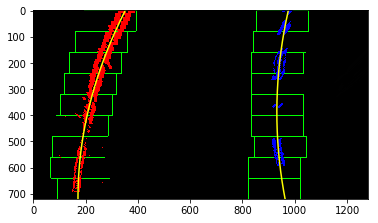

In [5]:
#now we have the bird eye view of the lane bird_eye find the lane boundary
left_fit,right_fit,out_img,ploty,left_fitx, right_fitx = fit_polynomial(bird_eye)

#get the left and right lane curvature
left_curverad, right_curverad,center= measure_curvature_pixels(ploty, left_fitx, right_fitx)
print("left curverad:",int(left_curverad),"right curverad:", int(right_curverad))

#get the distance to the center of the curve

#use the previous poly fit and plot the next search lane region with a margin to the ploy fit line
search_area =poly_search(out_img,left_fitx, right_fitx,ploty)

#warp the image back to the original image
lane_fit = warp_back(undist,Minv,left_fitx,right_fitx,ploty)
#cv2.imshow('fit',lane_fit)
#cv2.waitKey(5000)

put_text(lane_fit,int(left_curverad),int(right_curverad),center)
plt.imshow(out_img)














# The Line Class to keep some history parametres


In [6]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #the previous poly fit
        self.prev_poly_fit = None #[left_fit, right_fit,ploty]
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

# Put pipe line togehter


In [7]:
line = Line()
def pipeline(img):
    #run the first cell to get the image points and object points for camear undistortion
    undist = cv2.undistort(img, mtx, dist, None, mtx) #undistort the image

    #apply the threshold and bird eye transform
    Minv, bird_eye = bird_eye_transform(undist)

    #now we have the bird eye view of the lane bird_eye find the lane boundary
    if line.prev_poly_fit == None:
        left_fit,right_fit,out_img,ploty,left_fitx, right_fitx = fit_polynomial(bird_eye)
    else:
        left_fit,right_fit,out_img,ploty,left_fitx, right_fitx = fit_polynomial(bird_eye)
        
    #line.prev_poly_fit = [left_fit, right_fit,ploty]
        
        

    #get the left and right lane curvature
    left_curverad, right_curverad,center = measure_curvature_pixels(ploty, left_fitx, right_fitx)
    #print("left curverad:",left_curverad,"right curverad:", right_curverad)

    #get the distance to the center of the curve

    #use the previous poly fit and plot the next search lane region with a margin to the ploy fit line
    #search_area =poly_search(out_img,left_fitx, right_fitx,ploty)

    #warp the image back to the original image
    lane_fit = warp_back(undist,Minv,left_fitx,right_fitx,ploty)
    
    put_text(lane_fit,int(left_curverad),int(right_curverad),center)
    
    return lane_fit
    #plt.imshow(lane_fit)









## Test in the Video

[MoviePy] >>>> Building video ../output_images/project_video.mp4
[MoviePy] Writing video ../output_images/project_video.mp4


100%|█████████▉| 1260/1261 [04:20<00:00,  5.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/project_video.mp4 

CPU times: user 14min 13s, sys: 59.8 s, total: 15min 13s
Wall time: 4min 21s


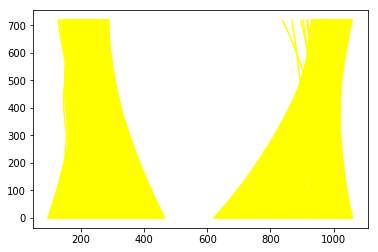

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    return pipeline(img)

white_output = '../output_images/project_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))